<a href="https://colab.research.google.com/github/Erkiperkki/IL2232/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
!pip install torch_geometric
import torch_geometric
from torch_geometric.utils import from_networkx
import networkx as nx


In [80]:
from google.colab import drive
drive.mount('/content/drive')
PATH="/content/drive/MyDrive/Embedded Systems Design Project"

#/content/drive/MyDrive/Embedded Systems Design Project/output

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import torch
from torch import Tensor
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import numpy as np

dataset=[]
graph_list=torch.load(PATH + "/IA_graph.csv")
for g in graph_list:
  d = from_networkx(g)

  nodes = g.nodes()
  edge_index = d.edge_index
  edge_label = d.label
  num_nodes = d.num_nodes

  data = HeteroData()
  edge_label = torch.FloatTensor( [float(i) for i in list(edge_label)])
  data["data"].node_id = torch.IntTensor( [int(i) for i in list(nodes)])

  data['data', 'edge', 'data'].edge_index = edge_index
  data['data', 'edge', 'data'].edge_label = edge_label

  dataset.append(data)

  # Save node indices:
  '''
  data.node_id = Tensor(list(B.nodes()))

  # Add the node features and edge indices:
  data.x = np.ones(B.number_of_nodes())

  data.edge_index = edge_index
  data.edge_label = edge_label
  data.number_of_nodes =  num_nodes

  '''
  # Add the node features and edge indices:
  #data["data"].x = np.ones(B.number_of_nodes())

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
#data = T.ToUndirected()(data)

In [82]:
# #generate fake/debugging dataset
# dataset=[]
# for i in range(1000):
#   dataset.append(data)

In [83]:

num_train_samples = int(0.7*len(dataset))

train_dataset = dataset[0:num_train_samples]
test_dataset = dataset[num_train_samples:]

In [84]:
# load graph object from file
#d = pickle.load(open('sampled_data.pickle', 'rb'))

In [85]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [86]:
tot_num_nodes=sum([data.num_nodes for data in dataset])

In [104]:

from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_user[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:

        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

        #ones=torch.ones(edge_feat_user.size(), dtype=torch.long)
        #return  (edge_feat_user * ones).sum(dim=-1)



class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:

        #self.movie_lin = torch.nn.Linear(1, hidden_channels)

        self.data_emb = torch.nn.Embedding(tot_num_nodes, hidden_channels)
        #self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata = (['data'], [('data',"edge",'data')]) )

        #(["node_id"],["edge_index"])

        #look here need to change metedata to all possible types

        '''
(['user', 'movie'],
 [('user', 'rates', 'movie'), ('movie', 'rev_rates', 'user')])

which node representations are learned for each node type in
metadata[0], and messages are exchanged between each edge type in
metadata[1], as denoted in the "Modeling Relational Data with Graph Convolutional Networks" <https://arxiv.org/abs/1703.06103>_ paper:

where x_dict and edge_index_dict denote dictionaries that
hold node features and edge connectivity information for each node type and
edge type, respectively.

        '''
        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "data": self.data_emb(data["data"].node_id),
          #"movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        }
        #print(x_dict)
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["data"],
            data['data', 'edge', 'data'].edge_index
            #data['data', 'edge', 'data'].edge_label_index,
        )

        return pred

model = Model(hidden_channels=64)
#model = GNN(hidden_channels=64)

print(model)

import tqdm
import torch.nn.functional as F
import torch
from torch import Tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 5):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data['data', 'edge', 'data'].edge_label

        #print(f"pred = {(ground_truth.type())}")
        #ground_truth*[1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1]

        # loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss = ((pred - ground_truth) ** 2).mean()


        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Model(
  (data_emb): Embedding(88, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (data__edge__data): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (data__edge__data): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)
Device: 'cpu'


100%|██████████| 19/19 [00:00<00:00, 176.69it/s]


Epoch: 001, Loss: 3.7409


100%|██████████| 19/19 [00:00<00:00, 179.09it/s]


Epoch: 002, Loss: 3.7841


100%|██████████| 19/19 [00:00<00:00, 168.21it/s]


Epoch: 003, Loss: 3.4137


100%|██████████| 19/19 [00:00<00:00, 174.38it/s]

Epoch: 004, Loss: 1.0536


In [105]:
#from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
for sampled_data in (test_dataset):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["data", "edge", "data"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
pred=[int(p) for p in pred]
ground_truth=[int(p) for p in ground_truth]

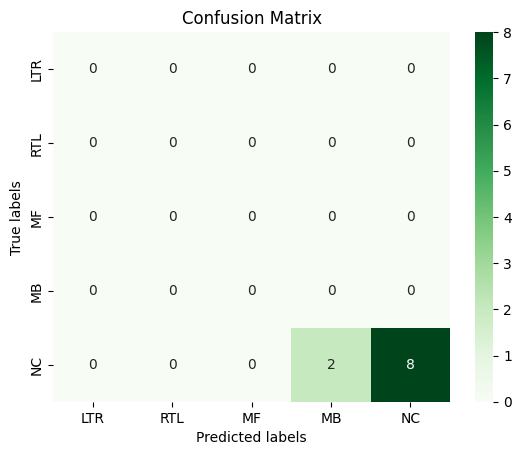

In [106]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

ax= plt.subplot()
cm = confusion_matrix(ground_truth, pred, labels=[0,1,2,3,4])

sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
x_labels=['LTR', 'RTL', 'MF', 'MB', 'NC']
y_labels=x_labels
ax.xaxis.set_ticklabels(x_labels); ax.yaxis.set_ticklabels(y_labels);
#auc = roc_auc_score(ground_truth, pred, multi_class="ovo")
# print()
# print(f"Validation AUC: {auc:.4f}")

In [107]:
#not used!!!
raise ValueError

ValueError: ignored

In [91]:
#try 2
from torch_geometric.nn import GraphConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(-1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 9)

    def forward(self, data):

        x, edge_index, batch = data["data"].node_id, data[("data", "edge", "data")].edge_index, data["data"].batch

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.dropout(x, p=0.1, training=self.training)

        x = self.lin(x)

        return x

model = GNN(hidden_channels=64)
print(model)

GNN(
  (conv1): GCNConv(-1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=9, bias=True)
)


In [92]:
#train_dataset

In [93]:
data.edge_index_dict


{('data',
  'edge',
  'data'): tensor([[0, 1],
         [1, 0]])}

In [94]:
metadata=data.metadata()
names = metadata[0] + [rel for _, rel, _ in metadata[1]]
for name in names:
  print(name)

data
edge


In [95]:
 data["edge"].edge_index

tensor([[0, 1],
        [1, 0]])

In [96]:
import tqdm
import torch.nn.functional as F
import torch
from torch import Tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cpu'


  0%|          | 0/19 [00:00<?, ?it/s]


IndexError: ignored

In [ ]:
i=1
#IG[data.edge_index[0][i].item()][2]
print(IG[data.edge_index[0][i].item()+1][data.edge_index[1][i].item()+1])

In [ ]:
data=from_networkx(IG)
print(data.edge_index)
edge_attr=[]
for i in range(len(data.edge_index[0])):
  print([data.edge_index[0][i]+1][0].item())
  t=(IG[data.edge_index[0][i].item()][data.edge_index[1][i].item()])
  print(t)
  edge_attr.append=t
edge_attr
#edge_attr= [IG[] for i in data.edge_index]
#print(edge_attr)


'''
edge_attr[i] corresponds to the edge
between edge_index[0][i] and edge_index[1][i].
'''


In [ ]:
edge_index=[for i in IG.edges()]


In [ ]:
! pip install dgl

# import torch.nn.functional as F

In [ ]:
import dgl
import torch.nn as nn
import numpy as np
import torch
import pandas as pd


In [ ]:
B=nx.read_edgelist(PATH + "/IA_graph.csv", data=True, edgetype=int, nodetype=int, create_using=nx.DiGraph)
nx.write_edgelist(B,PATH+"/IA_graph1.csv",data=["label"], delimiter ="," )


In [ ]:
B.edges(data=True)
d=from_networkx(B)
edge_index = d.edge_index
edge_label = d.label
num_nodes = d.num_nodes


In [ ]:
graph=pd.read_csv(PATH + "/IA_graph1.csv", header=None, names=["src",'dst','label'])
graph

In [ ]:
src = np.random.randint(0, 100, 500)
dst = np.random.randint(0, 100, 500)
# make it symmetric
edge_pred_graph = dgl.graph((np.concatenate([src, dst]), np.concatenate([dst, src])))
# synthetic node and edge features, as well as edge labels
edge_pred_graph.ndata['feature'] = torch.randn(100, 10)
edge_pred_graph.edata['feature'] = torch.randn(1000, 10)
edge_pred_graph.edata['label'] = torch.randn(1000)
# synthetic train-validation-test splits
edge_pred_graph.edata['train_mask'] = torch.zeros(1000, dtype=torch.bool).bernoulli(0.6)

In [ ]:
edge_pred_graph

In [ ]:
B.edges(data=True)

In [ ]:
edge_pred_graph.num_edges()

In [ ]:
B=nx.read_edgelist(PATH + "/IA_graph.csv", data=True, edgetype=int, nodetype=int, create_using=nx.DiGraph)
edge_pred_graph=dgl.from_networkx(B, edge_attrs=["label"])
#edge_pred_graph.edata['label'] = graph.label
# synthetic train-validation-test splits
edge_pred_graph.edata['train_mask'] = torch.zeros(edge_pred_graph.num_edges(), dtype=torch.bool).bernoulli(0.6)
edge_pred_graph.edata['train_mask']


In [ ]:
print(len(graph))
src = graph.src
dst = graph.dst
num_edges=len(graph)
# make it symmetric
edge_pred_graph = dgl.graph((np.concatenate([src, dst]), np.concatenate([dst, src])))
# synthetic node and edge features, as well as edge labels
#edge_pred_graph.ndata['feature'] = torch.randn(100, 10)
# edge_pred_graph.edata['feature'] = graph.label
edge_pred_graph.edata['label'] = graph.label
# synthetic train-validation-test splits
edge_pred_graph.edata['train_mask'] = torch.zeros(edge_pred_graph.num_edges(), dtype=torch.bool).bernoulli(0.6)

In [ ]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        print(graph)
        print(inputs)
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h


import dgl.function as fn
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']


class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']


class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

from torch import Tensor
# node_features = edge_pred_graph.ndata['feature']
edge_label = edge_pred_graph.edata['label']
train_mask = edge_pred_graph.edata['train_mask']
model = Model(1, 20, 10)
opt = torch.optim.Adam(model.parameters())


pred = model(edge_pred_graph, Tensor())
loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
opt.zero_grad()
loss.backward()
opt.step()
print(loss.item())


# for epoch in range(10):
#     pred = model(edge_pred_graph, Tensor())
#     loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
#     opt.zero_grad()
#     loss.backward()
#     opt.step()
#     print(loss.item())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class EdgePredictor(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(EdgePredictor, self).__init__(aggr='max')  # Use max pooling for message aggregation

        self.node_idx = torch.arange(in_channels, dtype=torch.long)
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, x, edge_index):
        # x: Node features
        # edge_index: Graph connectivity

        # Add self-loops for the message passing
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Calculate the normalized degree for each node
        deg = degree(edge_index[0], x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        # Calculate the normalized adjacency matrix
        norm = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
        edge_index_norm = Tensor((2,200))
        print((edge_index / norm).size())
        print((edge_index).size())
        edge_index_norm = (edge_index / norm).int
        return self.propagate(edge_index=edge_index_norm, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j):
        return x_j

    def update(self, aggr_out, x):
        aggr_out = torch.cat([aggr_out, x[self.node_idx]], dim=-1)
        aggr_out = F.relu(self.lin(aggr_out))
        return aggr_out


# Example usage:
# Initialize the model
model = GNNEdgeClassifier(in_channels=1, hidden_channels=32, out_channels=11)  # 11 classes (0 to 10)

# Example data (replace with your own data)
x = torch.randn(100, 1)  # Node features (not used in this example)
edge_index = torch.randint(0, 100, (2, 200), dtype=torch.long)  # Random edge connectivity
edge_labels = torch.randint(0, 11, (200,), dtype=torch.long)  # Random edge labels (0 to 10)

# Forward pass
predictions = model(x, edge_index)

# Calculate loss (replace with your own loss function)
criterion = nn.CrossEntropyLoss()
loss = criterion(predictions, edge_labels)
